# AgML Models

The `agml.models` module contains pretrained models and benchmarks on each of the public datasets in AgML. Currently, AgML provides an easy-to-use pipeline for inferencing with these models and evaluating them on common metrics. If you want to train the models, we have provided examples with which to get started in the `experiments` directory.

In [1]:
!pip install -q agml


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -q pytorch-lightning ensemble-boxes effdet==0.2.4


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt

import agml
import agml.models

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading Benchmarks

The `agml.models` module contains three primary models, based on their task:

| AgML Endpoint | Architecture|
|---|---|
| `agml.models.ClassificationModel`| EfficientNetB4 |
| `agml.models.SegmentationModel`| DeepLabV3 (ResNet50) |
| `agml.models.DetectionModel`| EfficientDetD4 |

By default, when downloading a benchmark, it will be saved to **`~/.agml/models`** (although this can be overriden using `agml.backend.set_model_save_path`).

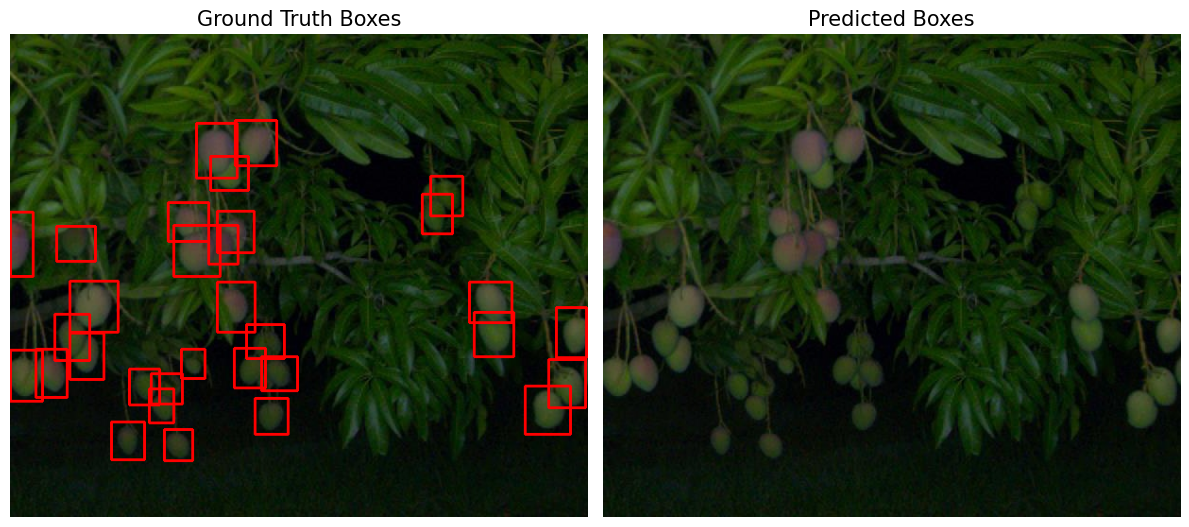

In [4]:
# Construct a one-class model.
detector = agml.models.DetectionModel(num_classes=1)

# Visualize predictions.
grape_day = agml.data.AgMLDataLoader("mango_detection_australia")
image, truth = grape_day[0]
pred_boxes, *_ = detector.predict(image)
_ = agml.viz.show_object_detection_truth_and_prediction(
    image, real_boxes=truth, predicted_boxes=pred_boxes
)

By default, the model uses COCO weights, and thus the predictions are highly inaccurate. To load a benchmark for a model, use the `load_benchmark` method and input the AgML dataset whose benchmark you want.

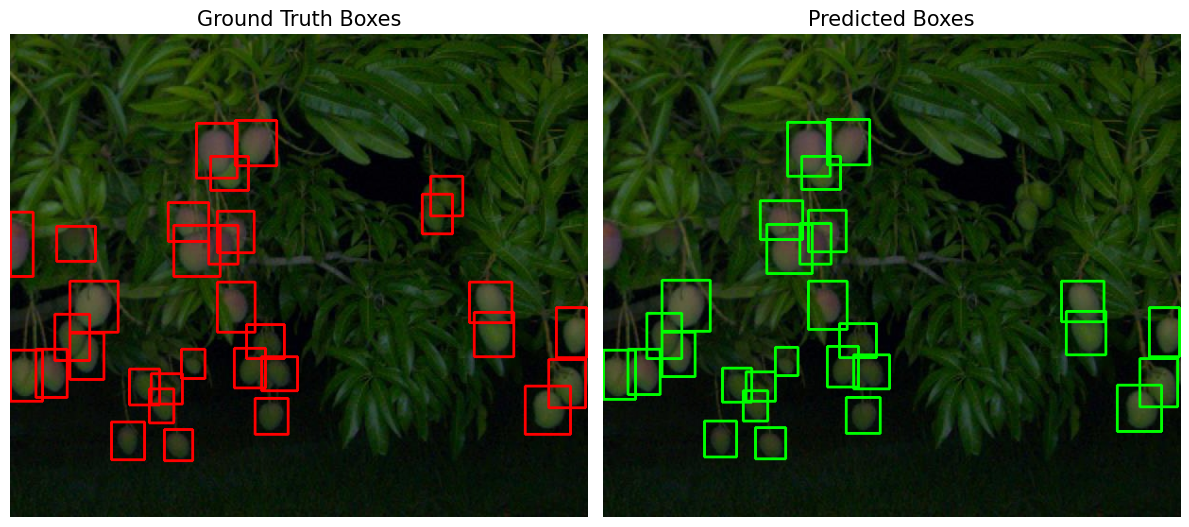

In [5]:
# Load the `mango_detection_australia` benchmark.
detector.load_benchmark("mango_detection_australia")

# Visualize predictions.
image, truth = grape_day[0]
pred_boxes, *_ = detector.predict(image)
_ = agml.viz.show_object_detection_truth_and_prediction(
    image, real_boxes=truth, predicted_boxes=pred_boxes
)

You can use the `benchmark` property to view useful information regarding the model's benchmark.

In [6]:
print(detector.benchmark)

<Benchmark mango_detection_australia>({'metric': {'mAP': 95.32}, 'hyperparameters': {'epochs': 50, 'model_config': {'box_loss_weight': 100.0, 'image_size': [512, 512], 'confidence_threshold': 0.3}, 'optimizer_config': {'lr': 0.0002}}})


We can do the same for semantic segmentation models:

/Users/amogh/Projects/AgML/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amogh/Projects/AgML/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


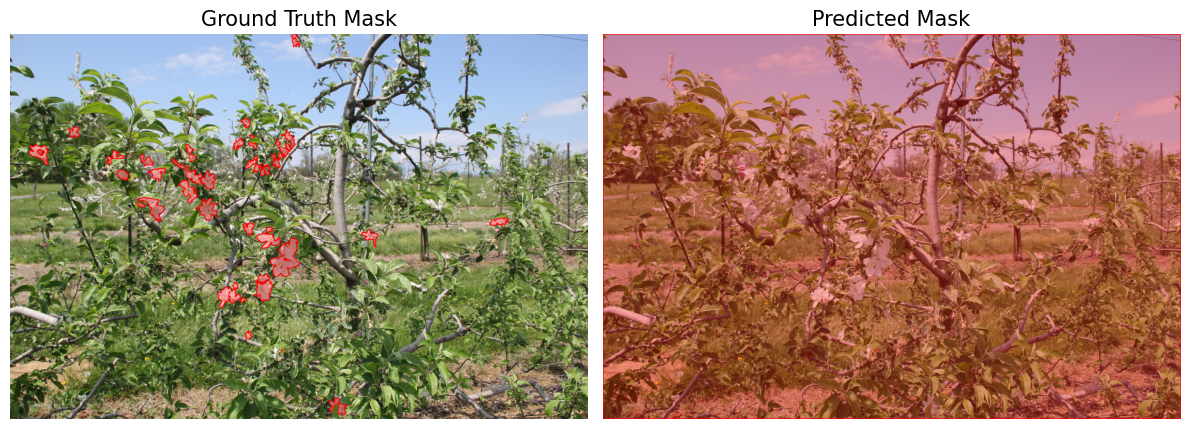

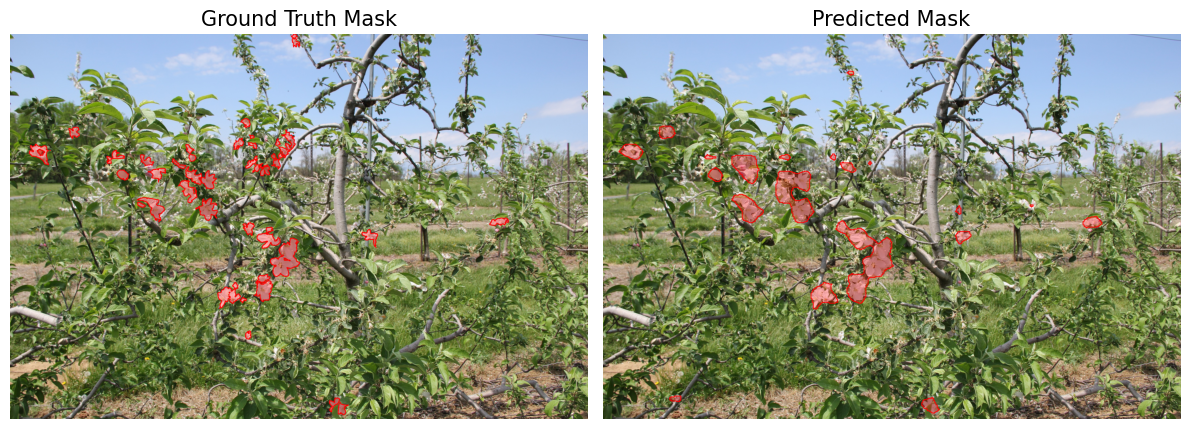

In [7]:
# Construct a one-class model.
seg = agml.models.SegmentationModel(num_classes=1)

# Visualize predictions.
apple_flower = agml.data.AgMLDataLoader("apple_flower_segmentation")
image, truth = apple_flower[0]
pred_mask = seg.predict(image)
_ = agml.viz.show_semantic_segmentation_truth_and_prediction(
    image, real_mask=truth, predicted_mask=pred_mask
)

# Load the `apple_flower_segmentation` benchmark.
seg.load_benchmark("apple_flower_segmentation")

# Visualize predictions.
image, truth = apple_flower[0]
pred_mask = seg.predict(image)
_ = agml.viz.show_semantic_segmentation_truth_and_prediction(
    image, real_mask=truth, predicted_mask=pred_mask
)

## Evaluating Models

The `agml.models` package also comes with a sub-module, `agml.models.metrics`, with common metrics for agricultural deep learning tasks. Currently, it includes `agml.models.metrics.MeanAveragePrecision`, for object detection, and `agml.models.metrics.Accuracy`, for image classification.

You can either use the metrics on your own, in a training loop, or implicitly use them by calling `model.evaluate()` on an AgML model. For example, on an object detection model:

In [8]:
# Construct a model with a benchmark for `fruit_detection_worldwide`.
detector = agml.models.DetectionModel(num_classes=7)
detector.load_benchmark("fruit_detection_worldwide")
# detector.cuda()

# Evaluate on a subset of the dataset.
dataset = agml.data.AgMLDataLoader("fruit_detection_worldwide").take_random(100)
result = detector.evaluate(dataset)
print(f"Calculated Mean Average Precision: {result.numpy() * 100}%")

Calculating Mean Average Precision: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

Calculated Mean Average Precision: 71.16941809654236%


Or, a semantic segmentation model:

In [9]:
# Construct a model with a benchmark for `rice_seedling_segmentation`.
seg = agml.models.SegmentationModel(num_classes=1)
seg.load_benchmark("apple_segmentation_minnesota")

# Evaluate on a subset of the dataset.
dataset = agml.data.AgMLDataLoader("apple_segmentation_minnesota").take_random(50)
result = seg.evaluate(dataset)
print(f"Calculated intersection-over-union: {result * 100}%")

/Users/amogh/Projects/AgML/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amogh/Projects/AgML/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Calculating Mean Intersection Over Union: 100%|██████████| 50/50 [00:25<00:00,  1.93it/s, miou=0.623]

Calculated intersection-over-union: 62.33510971069336%


## Additional Training Tools

The `agml.models` module also comes with additional tools which can be useful when attempting to train your own model.

The `agml.models.losses` module contains standard loss functions for training models, such as `agml.models.losses.DiceLoss`, for semantic segmentation.

The `agml.models.preprocessing` submodule contains preprocessing tools, such as the `EfficientDetPreprocessor`, which prepares data for the EfficientDet format (`yxyx` annotations, PyTorch conversion, etc). It can be used as follows:

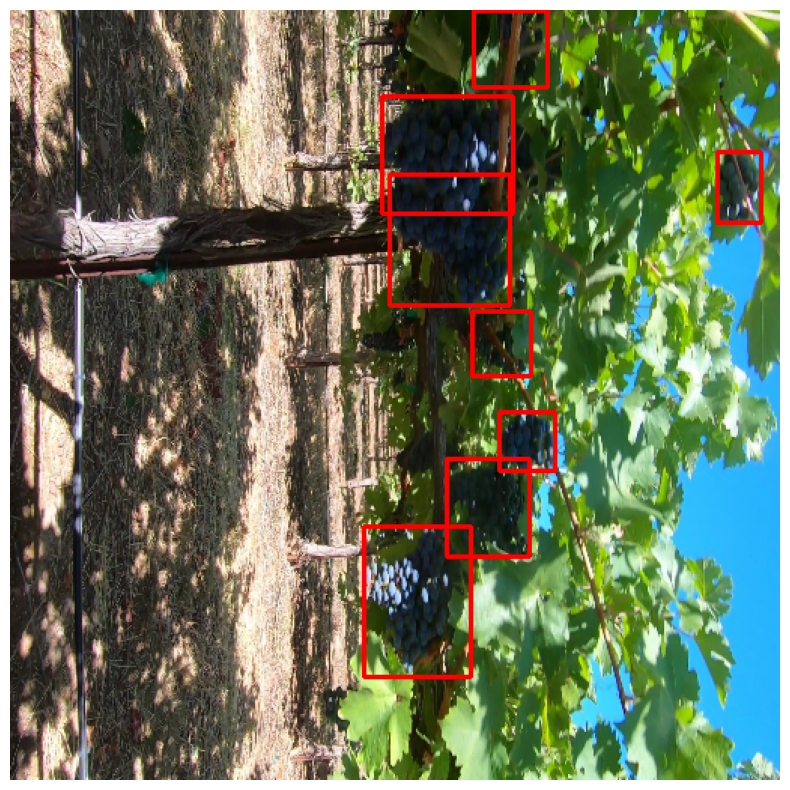

In [10]:
import albumentations as A

# Construct a loader and apply the preprocessor.
loader = agml.data.AgMLDataLoader("grape_detection_californiaday")
processor = agml.models.preprocessing.EfficientDetPreprocessor(
    image_size=512, augmentation=[A.RandomRotate90()]
)
loader.transform(dual_transform=processor)

# Inspect a data sample.
image, truth = loader[0]
_ = agml.viz.show_image_and_boxes(image, truth, bbox_format="efficientdet")

## Next Steps

You're now ready to use the `agml.models` module with pretrained models and benchmarks. We aim to add support for training models and extend inference capabilities in the future.